In [3]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import os
from torch.autograd import Variable
from scipy.stats import norm

In [4]:
N=60000
Z = np.random.normal(0, 1, N)
eps = np.random.multivariate_normal([0,0], [[0.02, 0], [0, 0.02]], N)
u = (0.6+1.8*norm.cdf(Z))*np.pi
x1 = np.cos(u)/(np.sqrt(2)*np.power(np.sin(u),2)+1) + eps[:,0]
x2 = np.sqrt(2)*np.cos(u)*np.sin(u)/(np.power(np.sin(u),2)+1) + eps[:,1]

X_temp = np.vstack((x1,x2)).transpose()
X = X_temp[:40000]
X_test = X_temp[40000:]

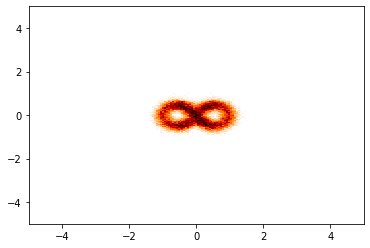

In [5]:
plt.hist2d(X[:,0],X[:,1],bins=50,cmap="gist_heat_r")
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.savefig('figure8_diagonal/fig8_training.png')

In [6]:
mb_size = 64
Z_dim = 2
X_dim = X.shape[1]
h_dim = 128
c = 0
lr = 1e-5

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [7]:
# =============================== Q(z|X) ======================================

Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)


def Q(X):
    h = nn.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    z_mu = h @ Whz_mu + bhz_mu.repeat(h.size(0), 1)
    z_var = h @ Whz_var + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var


def sample_z(mu, log_var):
    eps = Variable(torch.randn(mu.shape[0], Z_dim))
    return mu + torch.exp(log_var / 2) * eps


In [8]:
# =============================== P(X|z) ======================================

Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whmu = xavier_init(size=[h_dim, X_dim])
bhmu = Variable(torch.zeros(X_dim), requires_grad=True)

Whsigma = xavier_init(size=[h_dim, X_dim])
bhsigma = Variable(torch.zeros(X_dim), requires_grad=True)

def P(z):
    h = torch.tanh(z @ Wzh + bzh.repeat(z.size(0), 1))
    X_mu = (h @ Whmu + bhmu.repeat(h.size(0), 1))
    X_sigma = (h @ Whsigma + bhsigma.repeat(h.size(0), 1))
    return X_mu, X_sigma


In [9]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.data = torch.flatten(self.data, start_dim=1)
        self.target = torch.from_numpy(target).float()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [10]:
dataset = MyDataset(X, X)
loader = DataLoader(
    dataset,
    batch_size=mb_size,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

# for batch_idx, (data, target) in enumerate(loader):
#     print('Batch idx {}, data shape {}, target shape {}'.format(
#         batch_idx, data.shape, target.shape))


In [11]:
# =============================== TRAINING ====================================

params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var,
          Wzh, bzh, Whmu, bhmu, Whsigma, bhsigma]

solver = optim.Adam(params, lr=lr)

loss_epoch = []
# loss_batch = []
x_from_prior = []
x_from_test = []

Z = torch.Tensor(np.random.multivariate_normal([0,0], [[1,0],[0,1]], 10**4))
X_sample_mu, X_sample_sigma = P(Z)
X_sample_sigma_square = torch.diag_embed(torch.exp(X_sample_sigma*2), dim1=-2, dim2=-1)
kernels = MultivariateNormal(X_sample_mu, X_sample_sigma_square)

x_from_prior.append(kernels.sample().cpu().detach().numpy())

test_data = torch.from_numpy(X_test).float()
Z_mu, Z_var = Q(test_data)
Z = sample_z(Z_mu, Z_var)
X_sample_mu, X_sample_sigma = P(Z)
X_sample_sigma_square = torch.diag_embed(torch.exp(X_sample_sigma*2), dim1=-2, dim2=-1)
kernels = MultivariateNormal(X_sample_mu, X_sample_sigma_square)

x_from_test.append(kernels.sample().cpu().detach().numpy())
            
for it in range(200):
    for x_batch, y_batch in loader:
        # Forward
        z_mu, z_var = Q(x_batch)
        z = sample_z(z_mu, z_var)
        x_sample_mu, x_sample_sigma = P(z)
            

        # Loss
        #recon_loss = nn.binary_cross_entropy(x_sample, x_batch, size_average=False) / mb_size  # Bernoulli
        x_sample_sigma_square = torch.diag_embed(torch.exp(x_sample_sigma*2), dim1=-2, dim2=-1)
        kernels = MultivariateNormal(x_sample_mu, x_sample_sigma_square)
#         recon_loss = kernels.log_prob(x_batch[:,None,:]).mean()
        recon_loss = -1*kernels.log_prob(x_batch).mean()
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
        loss = recon_loss + kl_loss

        # Backward
        loss.backward()

        # Update
        solver.step()

        # Housekeeping
        for p in params:
            if p.grad is not None:
                data = p.grad.data
                p.grad = Variable(data.new().resize_as_(data).zero_())
     
    # Print loss after each epoch
    loss_epoch.append(loss.item())
    print('Iter-{}; Loss: {:.4}'.format(it+1, loss.item()))

    # generate samples
    Z = torch.Tensor(np.random.multivariate_normal([0,0], [[1,0],[0,1]], 10**4))
    X_sample_mu, X_sample_sigma = P(Z)
    X_sample_sigma_square = torch.diag_embed(torch.exp(X_sample_sigma*2), dim1=-2, dim2=-1)
    kernels = MultivariateNormal(X_sample_mu, X_sample_sigma_square)

    x_from_prior.append(kernels.sample().cpu().detach().numpy())

    test_data = torch.from_numpy(X_test).float()
    Z_mu, Z_var = Q(test_data)
    Z = sample_z(Z_mu, Z_var)
    X_sample_mu, X_sample_sigma = P(Z)
    X_sample_sigma_square = torch.diag_embed(torch.exp(X_sample_sigma*2), dim1=-2, dim2=-1)
    kernels = MultivariateNormal(X_sample_mu, X_sample_sigma_square)

    x_from_test.append(kernels.sample().cpu().detach().numpy())

Iter-1; Loss: 5.703
Iter-2; Loss: 4.252
Iter-3; Loss: 3.318
Iter-4; Loss: 3.273
Iter-5; Loss: 2.691
Iter-6; Loss: 2.711
Iter-7; Loss: 2.474
Iter-8; Loss: 2.301
Iter-9; Loss: 2.137
Iter-10; Loss: 2.028
Iter-11; Loss: 1.967
Iter-12; Loss: 1.858
Iter-13; Loss: 1.752
Iter-14; Loss: 1.699
Iter-15; Loss: 1.687
Iter-16; Loss: 1.685
Iter-17; Loss: 1.551
Iter-18; Loss: 1.579
Iter-19; Loss: 1.464
Iter-20; Loss: 1.432
Iter-21; Loss: 1.409
Iter-22; Loss: 1.51
Iter-23; Loss: 1.483
Iter-24; Loss: 1.486
Iter-25; Loss: 1.295
Iter-26; Loss: 1.403
Iter-27; Loss: 1.511
Iter-28; Loss: 1.551
Iter-29; Loss: 1.507
Iter-30; Loss: 1.45
Iter-31; Loss: 1.375
Iter-32; Loss: 1.418
Iter-33; Loss: 1.577
Iter-34; Loss: 1.511
Iter-35; Loss: 1.48
Iter-36; Loss: 1.435
Iter-37; Loss: 1.286
Iter-38; Loss: 1.472
Iter-39; Loss: 1.565
Iter-40; Loss: 1.438
Iter-41; Loss: 1.487
Iter-42; Loss: 1.412
Iter-43; Loss: 1.41
Iter-44; Loss: 1.388
Iter-45; Loss: 1.394
Iter-46; Loss: 1.487
Iter-47; Loss: 1.373
Iter-48; Loss: 1.595
Iter-

In [13]:
np.save('figure8_diagonal/diagonal_fig8_loss',loss_epoch)

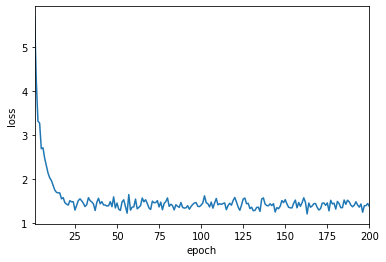

In [14]:
plt.plot(np.arange(1,201),loss_epoch)
plt.xlim(1,200)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('figure8_diagonal/fig8_loss_epoch.png')

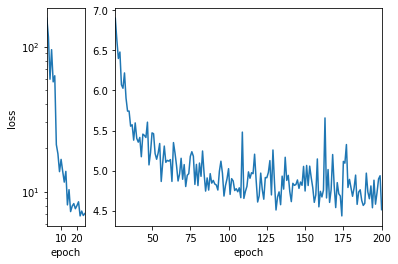

In [25]:
gs = gridspec.GridSpec(1, 2, width_ratios=[1,7])  #wspace=0.35 
ax0 = plt.subplot(gs[0])
ax0.plot(np.arange(1,26),loss_epoch[:25])
ax0.set_xlim(1,25)
ax0.set_yscale('log')
ax0.set_xlabel('epoch')
ax0.set_ylabel('loss')

ax1 = plt.subplot(gs[1])
ax1.plot(np.arange(26,201),loss_epoch[25:])
ax1.set_xlim(26,200)
ax1.set_xlabel('epoch')

plt.savefig('figure8_diagonal/fig8_loss_epoch_bypart.png')

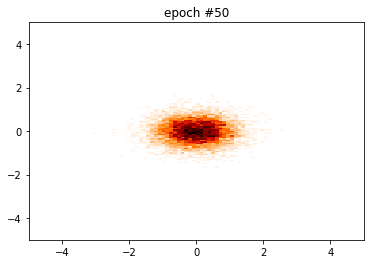

In [45]:
i +=5
plt.hist2d(x_from_prior[i][:,0],x_from_prior[i][:,1],bins=50,cmap="gist_heat_r")
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title('epoch #'+str((i)))
plt.savefig('figure8_diagonal/fig8_from_prior_epoch'+str((i))+'.png')

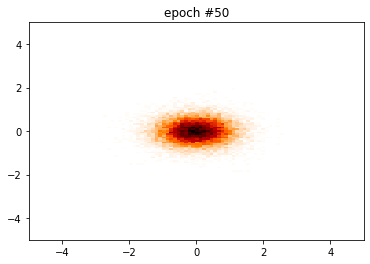

In [46]:
plt.hist2d(x_from_test[i][:,0],x_from_test[i][:,1],bins=50,cmap="gist_heat_r")
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title('epoch #'+str((i)))
plt.savefig('figure8_diagonal/fig8_from_test_epoch'+str((i))+'.png')

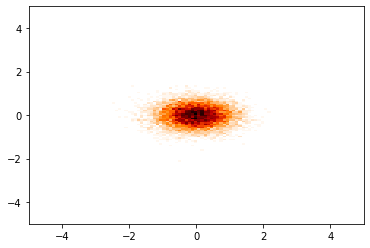

In [17]:
plt.hist2d(x_from_prior[-1][:,0],x_from_prior[-1][:,1],bins=50,cmap="gist_heat_r")
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.savefig('figure8_diagonal/fig8_from_prior_final.png')

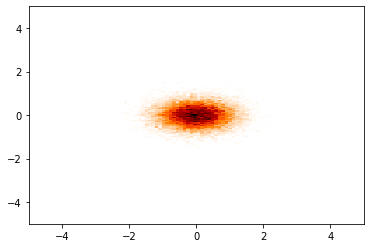

In [18]:
plt.hist2d(x_from_test[-1][:,0],x_from_test[-1][:,1],bins=50,cmap="gist_heat_r")
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.savefig('figure8_diagonal/fig8_from_test_final.png')

In [17]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
%notebook inline

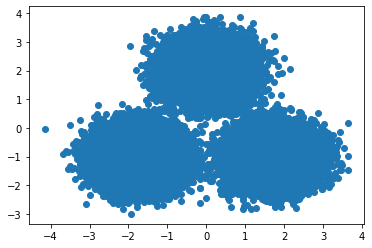

In [48]:
c = np.vstack((np.sin(np.asarray([1,2,3])*np.pi/3*2),np.cos(np.asarray([1,2,3])*np.pi/3*2))).transpose()
X, y = make_blobs(n_samples=60000, n_features=2, random_state=0,cluster_std=0.5, centers=2*c)
plt.scatter(X[:,0],X[:,1])

In [37]:
c = np.vstack((np.sin(np.asarray([1,2,3])*np.pi/3*2),np.cos(np.asarray([1,2,3])*np.pi/3*2)))

In [96]:
from scipy.stats import norm
Z = np.random.normal(0, 1, 10**6)
eps = np.random.multivariate_normal([0,0], [[0.2, 0], [0, 0.2]], 10**6)
u = 2*np.pi/(1+np.exp(-0.5*np.pi*Z))
t = 2*np.tanh(10*u-20*np.floor(0.5*u)-10)+4*np.floor(0.5*u)+2.
x1 = np.cos(t) + eps[:,0]
x2 = np.sin(t) + eps[:,1]

In [105]:
X = np.vstack((x1,x2)).transpose()

In [106]:
X.shape

(1000000, 2)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-3.04983772, -2.92868705, -2.80753638, -2.68638571, -2.56523504,
        -2.44408437, -2.32293369, -2.20178302, -2.08063235, -1.95948168,
        -1.83833101, -1.71718034, -1.59602967, -1.474879  , -1.35372833,
        -1.23257766, -1.11142699, -0.99027632, -0.86912565, -0.74797498,
        -0.62682431, -0.50567364, -0.38452297, -0.26337229, -0.14222162,
        -0.02107095,  0.10007972,  0.22123039,  0.34238106,  0.46353173,
         0.5846824 ,  0.70583307,  0.82698374,  0.94813441,  1.06928508,
         1.19043575,  1.31158642,  1.43273709,  1.55388776,  1.67503843,
         1.7961891 ,  1.91733978,  2.03849045,  2.15964112,  2.28079179,
         2.40194246,  2.52309313,  2.6442438 ,  2.76539447,  2.88654514,
         3.00769581])

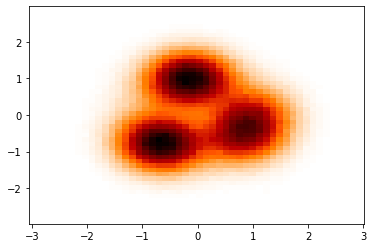

In [102]:
plt.hist2d(x1,x2,bins=50,cmap="gist_heat_r")

In [34]:
Z = torch.Tensor(np.random.multivariate_normal([0,0], [[1,0],[0,1]], 10**4))
X_sample_mu, X_sample_sigma = P(Z)
X_sample_sigma_square = torch.diag_embed(torch.exp(X_sample_sigma*2), dim1=-2, dim2=-1)
kernels = MultivariateNormal(X_sample_mu, X_sample_sigma_square)

In [38]:
kernels.sample().cpu().detach().numpy()

array([[ -2.1985157 ,  16.429544  ],
       [ -1.0646874 ,  11.973606  ],
       [ -2.16642   ,  -7.249029  ],
       ...,
       [ -0.98971474,  12.05236   ],
       [ -2.8292003 ,   5.080568  ],
       [ -3.467205  , -12.594424  ]], dtype=float32)

In [14]:
X_sample_mu.cpu().detach().numpy()

array([[-2.0470963 , -2.0716312 ],
       [-1.9909204 , -0.74431396],
       [-1.8837683 , -1.8002567 ],
       ...,
       [-1.9283814 ,  0.184941  ],
       [-2.000694  , -1.1147143 ],
       [-1.7880775 ,  2.073108  ]], dtype=float32)

In [15]:
sample_x = []
for mu, log_sigma in zip(X_sample_mu.cpu().detach().numpy(), X_sample_sigma.cpu().detach().numpy()):
    temp_x = np.random.multivariate_normal(mu, np.diag(np.exp(log_sigma*2)), 10)
    sample_x.append(temp_x)

In [16]:
sample_x = np.asarray(sample_x).reshape(-1,2)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-6.87137234, -6.6935641 , -6.51575586, -6.33794762, -6.16013938,
        -5.98233114, -5.8045229 , -5.62671466, -5.44890642, -5.27109818,
        -5.09328994, -4.9154817 , -4.73767346, -4.55986522, -4.38205698,
        -4.20424874, -4.0264405 , -3.84863226, -3.67082402, -3.49301578,
        -3.31520754, -3.1373993 , -2.95959106, -2.78178282, -2.60397458,
        -2.42616634, -2.2483581 , -2.07054986, -1.89274162, -1.71493338,
        -1.53712514, -1.3593169 , -1.18150866, -1.00370042, -0.82589218,
        -0.64808394, -0.4702757 , -0.29246746, -0.11465922,  0.06314902,
         0.24095726,  0.4187655 ,  0.59657374,  0.77438198,  0.95219022,
         1.12999846,  1.3078067 ,  1.48561494,  1.66342318,  1.84123142,
         2.01903966])

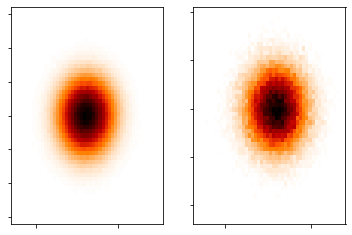

In [19]:
ax1=plt.subplot(1, 2, 1)
ax1.hist2d(sample_x[:,0],sample_x[:,1],bins=50,cmap="gist_heat_r")
ax2 = plt.subplot(1,2,2)
ax2.hist2d(X[:,0],X[:,1],bins=50,cmap="gist_heat_r")

In [21]:
np.mean(sample_x,axis=0)

array([-1.90887502,  0.03424988])

In [22]:
np.mean(X, axis=0)

array([-1.99846885,  0.01669429])

In [23]:
np.var(sample_x,axis=0)

array([ 0.99949447, 11.11678792])

In [24]:
np.var(X,axis=0)

array([ 1.00891079, 99.6919849 ])

In [122]:
sigma_sample = X_sample_sigma.cpu().detach().numpy()

In [123]:
mu = mu_sample[0]

In [124]:
log_sigma = sigma_sample[0]

In [125]:
np.random.multivariate_normal(mu, np.diag(np.exp(log_sigma*0.5)), 10)

array([[-0.59359856, -0.2779433 ],
       [-1.52953947, -0.19332419],
       [-1.70531358, -0.26078786],
       [-1.04972247, -0.75789738],
       [-0.69705988, -0.62217335],
       [-0.89998964,  0.34180836],
       [-0.67583555, -0.48873014],
       [-1.54048073, -1.39306325],
       [-0.12020233, -0.25016128],
       [-0.89124832,  0.43292988]])